### Import Libraries

In [ ]:
#https://www.kaggle.com/datasets/hitman1309/isic2018-10k-non-mv-384-jpg-stratified?authuser=0
#https://www.kaggle.com/datasets/aniladepu/isic2018-7-5k-non-mv-384-jpg-stratified?authuser=0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2

### Required Functions

In [105]:
# plot first 4 images of a class
def plot_images(images, label):
    num_images = min(len(images), 4)
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, 4, i+1)
        plt.imshow(images[i])
        plt.title(f"{label}")
        plt.axis('off')
    plt.show()

In [106]:
# create Data dictionery with classes as keys and array of its images as values
def create_data_dict(subdirs, data_frame, input_size=(224, 224)):
    main_dir = "/kaggle/input/isic2018-10k-mv-384-jpg-stratified /stratified_jpg_384_inpainted/"
    data_dict = {'MEL': [], 'NV': [], 'BCC': [], 'AKIEC': [], 'BKL': [], 'DF': [], 'VASC': []}
    
    for subdir in subdirs:
        print('Processing the sub-directory:', subdir)
        subdir_path = os.path.join(main_dir, subdir)
        img_files = os.listdir(subdir_path)
        
        for img_file in img_files:
            img_path = os.path.join(subdir_path, img_file)
            img_name = img_file.split('.')[0]
            label = get_label(img_name, data_frame)
            
            if not label:
                continue
            
            # Load and resize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, input_size)
            
            data_dict[label].append(img)
            
    return data_dict

In [107]:
# create dataset conventional for training
def convert_into_dataset(data_dict: dict, class_2_ind: dict):
    images, labels = [], []
    num_classes = len(class_2_ind)
    
    for label, imgs in data_dict.items():
        for img in imgs:
            images.append(img)
            one_hot_label = np.zeros(num_classes)
            class_index = class_2_ind[label]
            one_hot_label[class_index] = 1
            labels.append(one_hot_label)
        
    images = np.array(images)
    labels = np.array(labels)
    
    # Shuffle the data
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images, labels = images[indices], labels[indices]

    return images, labels

In [108]:
def plot_history(history):
    plt.figure(figsize=(14, 3))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])  
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left') 

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])  
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  

    plt.show()

In [109]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_images, test_labels):
    val_loss, val_accuracy = model.evaluate(test_images, test_labels)
    predictions = model.predict(test_images)
    
    true_labels = np.argmax(test_labels, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    
    report = classification_report(true_labels, predicted_labels, zero_division=0)
    
    return val_loss, val_accuracy, report

In [164]:
def extract_metrics_from_report(report):
    lines = report.split('\n')
    metrics = lines[-2].split()[2:]
    return [float(metric) for metric in metrics]

def create_comparison_table(model_name, test_loss, test_accuracy, report):
    metrics = extract_metrics_from_report(report)
    
    comparison_table = pd.DataFrame({
        'Model': [model_name],
        'Test Loss': [test_loss],
        'Test Accuracy': [test_accuracy],
        'Precision': [metrics[0]],
        'Recall': [metrics[1]],
        'F1-score': [metrics[2]]
    })
    
    return comparison_table

### Preprocessing

In [110]:
csv_train_data = pd.read_csv('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Training_LesionGroupings_WithoutDuplicates_Merged.csv')
csv_test_data = pd.read_csv('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Testing_GroundTruth.csv')
csv_train_data

,image,lesion_id,diagnosis_confirm_type,MEL,NV,BCC,AKIEC,BKL,DF,VASC,fold_number
0,ISIC_0028498,HAM_0000000,histopathology,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
1,ISIC_0027859,HAM_0000001,histopathology,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0
2,ISIC_0034246,HAM_0000002,histopathology,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
3,ISIC_0027886,HAM_0000003,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
4,ISIC_0024645,HAM_0000004,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...
7465,ISIC_0026322,HAM_0007624,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7466,ISIC_0033736,HAM_0007625,histopathology,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
7467,ISIC_0031300,HAM_0007626,serial imaging showing no change,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0
7468,ISIC_0029820,HAM_0007627,histopathology,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0


In [111]:
classes = csv_train_data.columns.tolist()
classes.remove('image')
classes.remove('lesion_id')
classes.remove('diagnosis_confirm_type')
classes.remove('fold_number')
print('Classes are :',classes)

class_2_ind = {}
ind_2_class = {}
for idx, cl in enumerate(classes):
    class_2_ind[cl] = idx
    ind_2_class[idx] = cl

print(class_2_ind)
print(ind_2_class)

Classes are : ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
{'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}


7470
[614, 5403, 327, 228, 727, 73, 98]


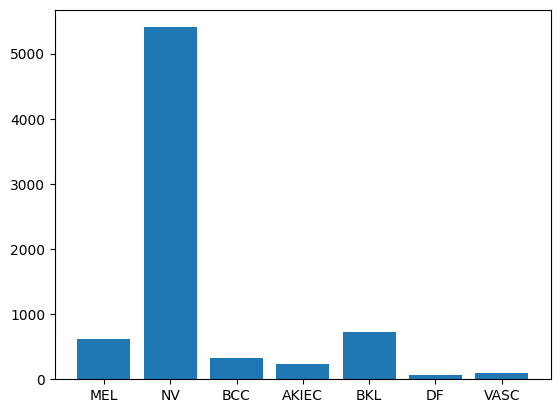

In [112]:
print(len(csv_train_data))

count = []
for cl in classes:
    val = int(csv_train_data[cl].sum())
    count.append(val)

print(count)
plt.bar(classes, count)
plt.show()

In [113]:
def get_label(image_name, data_frame):
    df_image = data_frame[data_frame['image'] == image_name]
    if df_image.empty:
        return None
    df_image.reset_index(drop=True, inplace=True)
    for col in df_image.columns:
        val = df_image[col].iloc[0]  # Get the value of the column for the first (and only) row
        if val == 1.0:
            return col
    return None


In [114]:
print('Label :', get_label('ISIC_0028498', csv_train_data))

Label : NV


In [115]:
train_subdirs = [f"train{i}" for i in range(15)]
test_subdir = ["test"]
data_dict = create_data_dict(train_subdirs, csv_train_data, input_size=(144, 144))
print("Train Data Dict is Created.")
test_data_dict = create_data_dict(test_subdir, csv_test_data, input_size=(144, 144))
print("Test Data Dict is Created.")

Processing the sub-directory: train0
Processing the sub-directory: train1
Processing the sub-directory: train2
Processing the sub-directory: train3
Processing the sub-directory: train4
Processing the sub-directory: train5
Processing the sub-directory: train6
Processing the sub-directory: train7
Processing the sub-directory: train8
Processing the sub-directory: train9
Processing the sub-directory: train10
Processing the sub-directory: train11
Processing the sub-directory: train12
Processing the sub-directory: train13
Processing the sub-directory: train14
Train Data Dict is Created.
Processing the sub-directory: test
Test Data Dict is Created.


### Plot all the lesions

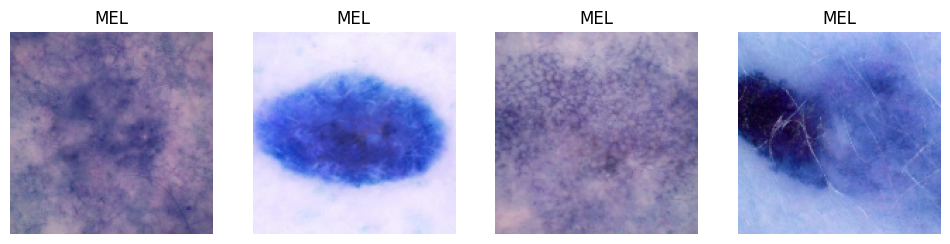

In [116]:
plot_images(train_data_dict['MEL'], 'MEL')

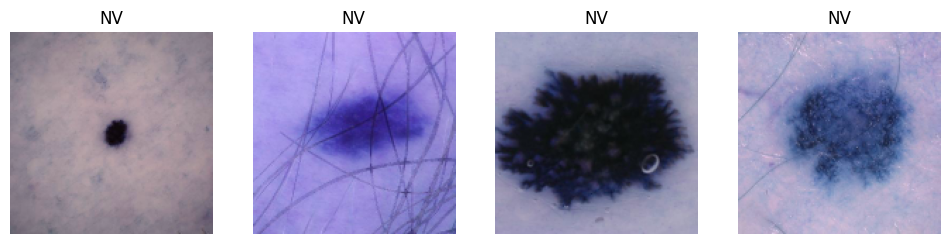

In [117]:
plot_images(train_data_dict['NV'], 'NV')

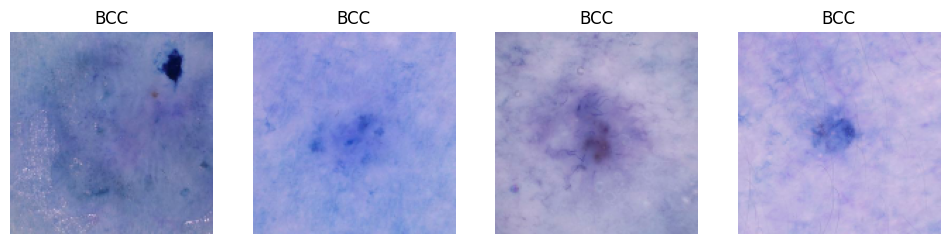

In [118]:
plot_images(train_data_dict['BCC'], 'BCC')

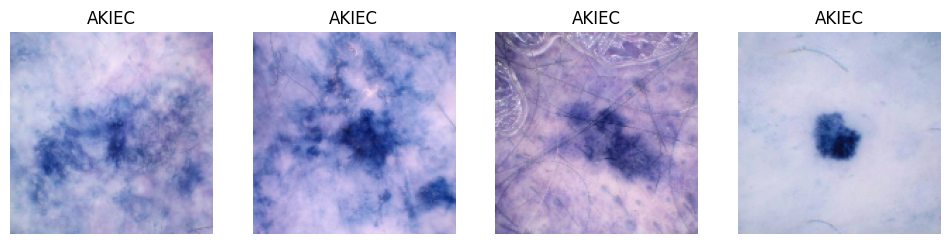

In [119]:
plot_images(train_data_dict['AKIEC'], 'AKIEC')

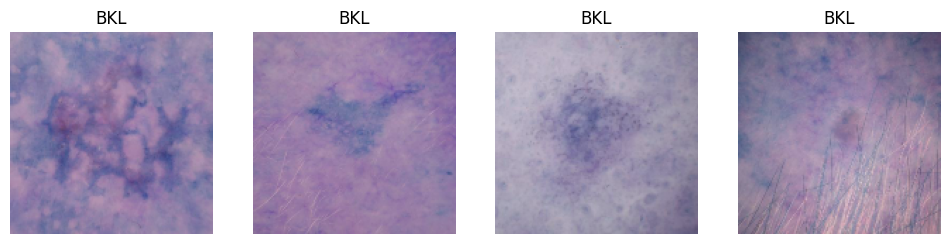

In [120]:
plot_images(train_data_dict['BKL'], 'BKL')

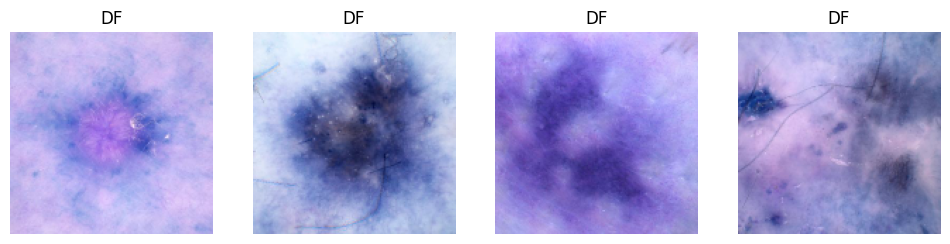

In [121]:
plot_images(train_data_dict['DF'], 'DF')

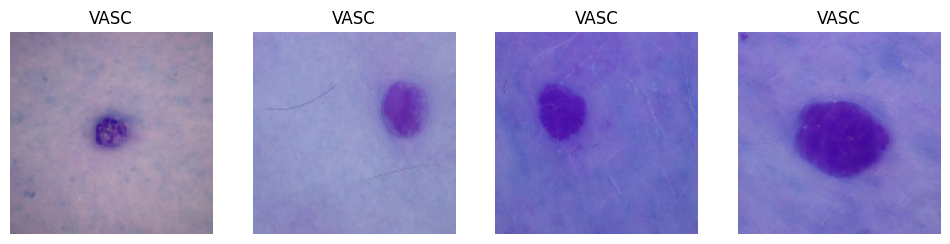

In [122]:
plot_images(train_data_dict['VASC'], 'VASC')

In [123]:
# getting the train and test datasets in conventional form
all_images, all_labels = convert_into_dataset(data_dict, class_2_ind)
print("Train-Val dataset created")
test_images, test_labels = convert_into_dataset(test_data_dict, class_2_ind)
print("Test dataset created")

Train-Val dataset created
Test dataset created


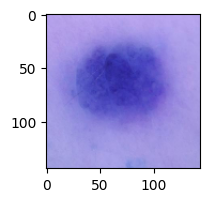

In [124]:
train_images.shape
plt.figure(figsize=(4, 2))
plt.imshow(train_images[0])

### Normalization

In [125]:
all_images_normalized = all_images.astype('float32') / 255.0
test_images_normalized = test_images.astype('float32') / 255.0

### Train and Val Split

In [126]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(all_images_normalized, all_labels, test_size=0.2, random_state=3)

print("Number of training samples:", len(train_images))
print("Number of validation samples:", len(val_images))

Number of training samples: 5976
Number of validation samples: 1494


### ResNet18 without Dilation

In [127]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def identity_block(x, filters, kernel_size=3, stride=1, l2_reg=0.0001):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1, l2_reg=0.0001):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet18_Without_Dilation(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=64, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=128, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=256, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=512, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=512, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#     x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet18')
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

In [128]:
resnet18_wo_d = ResNet18_Without_Dilation(inputShape=(144, 144, 3), num_classes=7)
history18_wo_d = resnet18_wo_d.fit(train_images, train_labels, batch_size=32, epochs=25, validation_data=(val_images, val_labels))

Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 58s 175ms/step - accuracy: 0.6761 - loss: 7.3498 - val_accuracy: 0.5803 - val_loss: 4.8750
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.7286 - loss: 4.1648 - val_accuracy: 0.7269 - val_loss: 3.4283
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7268 - loss: 3.2831 - val_accuracy: 0.7001 - val_loss: 2.6975
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7338 - loss: 2.4775 - val_accuracy: 0.6258 - val_loss: 2.4959
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7463 - loss: 1.9321 - val_accuracy: 0.7349 - val_loss: 1.7763
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7467 - loss: 1.6057 - val_accuracy: 0.3668 - val_loss: 2.2418
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7624 - loss: 1.4077 - val_accuracy: 0.7443 - val_loss: 1.4697
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.7640 - loss: 1.2022 -

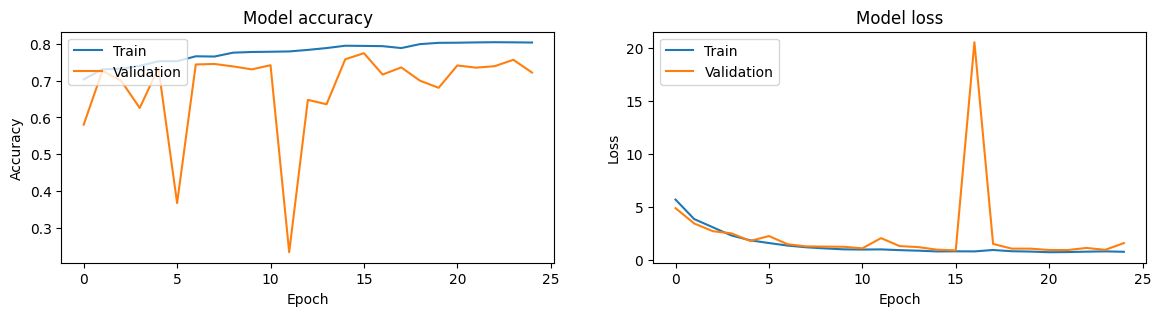

In [129]:
plot_history(history18_wo_d)

In [130]:
test_loss_18, test_accuracy_18, report_18 = evaluate_model(resnet18_wo_d, test_images_normalized, test_labels)
print("Test Loss:", test_loss_18)
print("Test Accuracy:", test_accuracy_18)
print("Classification Report:")
print(report_18)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6267 - loss: 2.3441


W0000 00:00:1713003231.733116      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
Test Loss: 2.3030941486358643
Test Accuracy: 0.6236772537231445
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.29      0.32       171
           1       0.68      0.95      0.79       909
           2       0.32      0.06      0.11        93
           3       0.25      0.09      0.14        43
           4       0.48      0.06      0.11       217
           5       0.00      0.00      0.00        44
           6       0.08      0.06      0.07        35

    accuracy                           0.62      1512
   macro avg       0.31      0.22      0.22      1512
weighted avg       0.54      0.62      0.54      1512



W0000 00:00:1713003236.515684      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### ResNet18 with dilation

In [131]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def identity_block(x, filters, kernel_size=3, stride=1, l2_reg=0.0001):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1, l2_reg=0.0001):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def dilated_convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x    

def ResNet18_With_Dilation(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=64, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=128, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1, l2_reg=0.001)
    x = identity_block(x, filters=256, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = dilated_convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3, l2_reg=0.001)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#     x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet18')
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

In [132]:
resnet18_w_d = ResNet18_With_Dilation(inputShape=(144, 144, 3), num_classes=7)
history18_w_d = resnet18_w_d.fit(train_images, train_labels, batch_size=32, epochs=25, validation_data=(val_images, val_labels))

Epoch 1/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 51s 161ms/step - accuracy: 0.6606 - loss: 5.7497 - val_accuracy: 0.1499 - val_loss: 4.2229
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7232 - loss: 3.1585 - val_accuracy: 0.7068 - val_loss: 2.7963
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7444 - loss: 2.3704 - val_accuracy: 0.7182 - val_loss: 5.1410
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7488 - loss: 1.8967 - val_accuracy: 0.6138 - val_loss: 1.9946
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7533 - loss: 1.5474 - val_accuracy: 0.7390 - val_loss: 1.3702
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7710 - loss: 1.2564 - val_accuracy: 0.7249 - val_loss: 1.4184
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7848 - loss: 1.1026 - val_accuracy: 0.7711 - val_loss: 1.0953
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7771 - loss: 1.0425 -

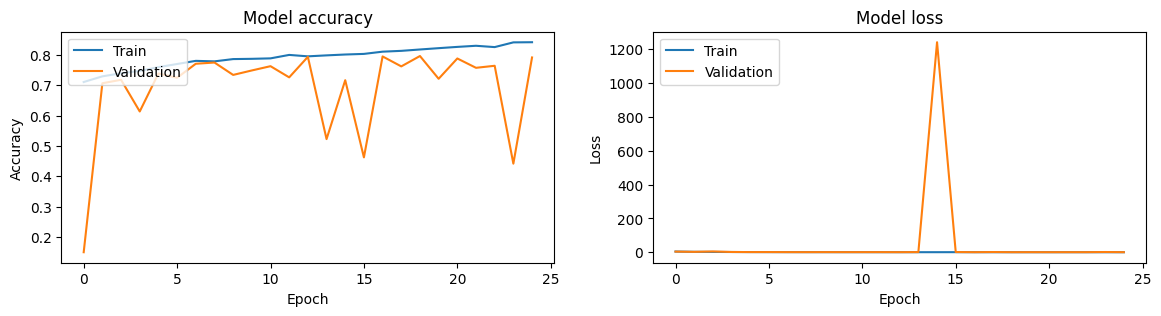

In [133]:
plot_history(history18_w_d)

In [134]:
test_loss_18_wd, test_accuracy_18_wd, report_18_wd = evaluate_model(resnet18_w_d, test_images_normalized, test_labels)
print("Test Loss:", test_loss_18_wd)
print("Test Accuracy:", test_accuracy_18_wd)
print("Classification Report:")
print(report_18_wd)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6897 - loss: 1.0750


W0000 00:00:1713003725.384304      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
Test Loss: 1.0874840021133423
Test Accuracy: 0.6838624477386475
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       171
           1       0.76      0.94      0.84       909
           2       0.37      0.11      0.17        93
           3       0.31      0.30      0.31        43
           4       0.49      0.39      0.43       217
           5       0.20      0.02      0.04        44
           6       0.87      0.37      0.52        35

    accuracy                           0.68      1512
   macro avg       0.50      0.35      0.39      1512
weighted avg       0.64      0.68      0.64      1512



W0000 00:00:1713003730.471786      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Comparing ResNet-18 Models

In [165]:
comp_table_18 = create_comparison_table('ResNet-18', test_loss_18, test_accuracy_18, report_18)
comp_table_18_wd = create_comparison_table('Dilated ResNet-18', test_loss_18_wd, test_accuracy_18_wd, report_18_wd)

comp_table_1 = pd.concat([comp_table_18, comp_table_18_wd], ignore_index=True)
comp_table_1

,Model,Test Loss,Test Accuracy,Precision,Recall,F1-score
0,ResNet-18,2.303094,0.623677,0.54,0.62,0.54
1,Dilated ResNet-18,1.087484,0.683862,0.64,0.68,0.64


## Tried ResNet152 below

### ResNet152 without Dilation

In [151]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam

def identity_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet152_Without_Dilation(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1)
    x = identity_block(x, filters=64, kernel_size=3)
    x = identity_block(x, filters=64, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3)
    x = identity_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet152')
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])    
    return model

In [152]:
resnet152_wo_d = ResNet152_Without_Dilation(inputShape=(144, 144, 3), num_classes=7)
history152_wo_d = resnet152_wo_d.fit(train_images, train_labels, batch_size=32, epochs=25, validation_data=(val_images, val_labels))

Epoch 1/25


W0000 00:00:1713005371.783663      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6834 - loss: 1.6202

W0000 00:00:1713005558.738882      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6836 - loss: 1.6172   

W0000 00:00:1713005568.839919      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.6838 - loss: 1.6143 - val_accuracy: 0.7169 - val_loss: 1.2337
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 622ms/step - accuracy: 0.7475 - loss: 0.7365 - val_accuracy: 0.7129 - val_loss: 1.2145
Epoch 3/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 623ms/step - accuracy: 0.7441 - loss: 0.7487 - val_accuracy: 0.7383 - val_loss: 0.7483
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 622ms/step - accuracy: 0.7603 - loss: 0.6651 - val_accuracy: 0.7376 - val_loss: 0.6990
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 622ms/step - accuracy: 0.7570 - loss: 0.6527 - val_accuracy: 0.7584 - val_loss: 0.6623
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 623ms/step - accuracy: 0.7809 - loss: 0.6347 - val_accuracy: 0.6988 - val_loss: 0.7956
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 622ms/step - accuracy: 0.7763 - loss: 0.6211 - val_accuracy: 0.7610 - val_loss: 37.7211
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 116s 623ms/step - accuracy: 0.7969 - loss: 0.5809

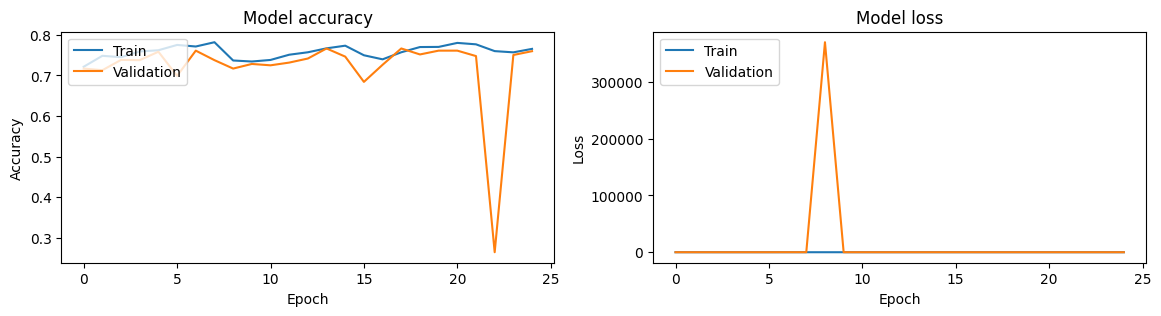

In [153]:
plot_history(history152_wo_d)

In [154]:
test_loss_152, test_accuracy_152, report_152 = evaluate_model(resnet152_wo_d, test_images_normalized, test_labels)
print("Test Loss:", test_loss_152)
print("Test Accuracy:", test_accuracy_152)
print("Classification Report:")
print(report_152)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 295ms/step - accuracy: 0.6525 - loss: 0.9701
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 353ms/step
Test Loss: 0.9558572769165039
Test Accuracy: 0.6633597612380981
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       171
           1       0.76      0.89      0.82       909
           2       0.43      0.19      0.27        93
           3       0.35      0.16      0.22        43
           4       0.38      0.34      0.36       217
           5       0.00      0.00      0.00        44
           6       0.50      0.29      0.36        35

    accuracy                           0.66      1512
   macro avg       0.41      0.34      0.36      1512
weighted avg       0.62      0.66      0.63      1512



### ResNet152 with Dilation

In [159]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam

def identity_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def dilated_convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters*4, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet152_With_Dilation(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1)
    x = identity_block(x, filters=64, kernel_size=3)
    x = identity_block(x, filters=64, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = identity_block(x, filters=128, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = identity_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = dilated_convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3)
    x = identity_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet152')
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

In [156]:
resnet152_w_d = ResNet152_With_Dilation(inputShape=(144, 144, 3), num_classes=7)
history152_w_d = resnet152_w_d.fit(train_images, train_labels, batch_size=32, epochs=25, validation_data=(val_images, val_labels))

Epoch 1/25


W0000 00:00:1713008614.347255      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6819 - loss: 1.5614

W0000 00:00:1713008796.252073      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.6821 - loss: 1.5584

W0000 00:00:1713008806.589996      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.6823 - loss: 1.5555 - val_accuracy: 0.7169 - val_loss: 1.2173
Epoch 2/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 630ms/step - accuracy: 0.7338 - loss: 0.7966 - val_accuracy: 0.7075 - val_loss: 0.8970
Epoch 4/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 117s 628ms/step - accuracy: 0.7533 - loss: 0.7693 - val_accuracy: 0.7169 - val_loss: 28186648.0000
Epoch 5/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.7310 - loss: 0.9220 - val_accuracy: 0.7169 - val_loss: 1.0229
Epoch 6/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.7389 - loss: 0.7673 - val_accuracy: 0.7169 - val_loss: 117648.8516
Epoch 7/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 117s 628ms/step - accuracy: 0.7291 - loss: 0.8174 - val_accuracy: 0.7209 - val_loss: 0.7958
Epoch 8/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.7291 - loss: 0.8525 - val_accuracy: 0.7169 - val_loss: 4.3658
Epoch 9/25
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.7168 - l

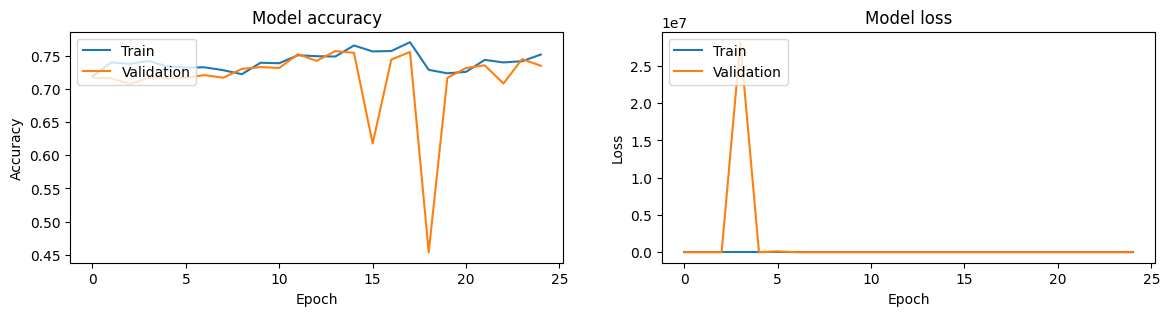

In [157]:
plot_history(history152_w_d)

In [158]:
test_loss_152_wd, test_accuracy_152_wd, report_152_wd = evaluate_model(resnet152_w_d, test_images_normalized, test_labels)
print("Test Loss:", test_loss_152_wd)
print("Test Accuracy:", test_accuracy_152_wd)
print("Classification Report:")
print(report_152_wd)

48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.6375 - loss: 1.0461
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step
Test Loss: 1.0355563163757324
Test Accuracy: 0.6335979104042053
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.30      0.35       171
           1       0.72      0.91      0.81       909
           2       0.27      0.03      0.06        93
           3       0.07      0.02      0.03        43
           4       0.34      0.34      0.34       217
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00        35

    accuracy                           0.63      1512
   macro avg       0.26      0.23      0.23      1512
weighted avg       0.55      0.63      0.58      1512



## Comparing ResNet-152 Models

In [166]:
comp_table_152 = create_comparison_table('ResNet-152', test_loss_152, test_accuracy_152, report_152)
comp_table_152_wd = create_comparison_table('Dilated ResNet-152', test_loss_152_wd, test_accuracy_152_wd, report_152_wd)

comp_table_2 = pd.concat([comp_table_152, comp_table_152_wd], ignore_index=True)
comp_table_2

,Model,Test Loss,Test Accuracy,Precision,Recall,F1-score
0,ResNet-152,0.955857,0.663360,0.62,0.66,0.63
1,Dilated ResNet-152,1.035556,0.633598,0.55,0.63,0.58
